In [30]:
import requests
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import re
import kaggle
import zipfile
import os
from datetime import datetime, timedelta
from collections import Counter
from wordcloud import WordCloud
import spacy
from summa import keywords
import nltk
from nltk.corpus import stopwords

In [3]:
# !pip install summa

**DATA COLLECTION AND PROCESSING**

downloading data on shares of the 50 largest companies by revenue in the Russian Federation for 2019-2023

In [4]:
# def get_moex_data(ticker, start_date, end_date):
#     all_data = []
#     start = 0
#     while True:
#         url = f"https://iss.moex.com/iss/history/engines/stock/markets/shares/boards/TQBR/securities/{ticker}.json"
#         params = {
#             "from": start_date,
#             "till": end_date,
#             "start": start,
#             "limit": 100,
#             "history.columns": "TRADEDATE,CLOSE,VOLUME"
#         }
#         response = requests.get(url, params=params)
#         if response.status_code != 200:
#             print(f"Ошибка при запросе данных для {ticker}: {response.status_code}")
#             break
#         data = response.json()
#         rows = data['history']['data']
#         if not rows:
#             break
#         all_data.extend(rows)
#         start += len(rows)
#         time.sleep(0.2)  
#     if not all_data:
#         return pd.DataFrame()
#     columns = data['history']['columns']
#     df = pd.DataFrame(all_data, columns=columns)
#     df = df[['TRADEDATE', 'CLOSE', 'VOLUME']]
#     df.columns = ['date', 'close price', 'volume']
#     df['Компания'] = ticker
#     return df

tickers = {
    'SBER': 'Сбербанк',
    'GAZP': 'Газпром',
    'LKOH': 'Лукойл',
    'ROSN': 'Роснефть',
    'NVTK': 'Новатэк',
    'GMKN': 'ГМК Норильский никель',
    'TATN': 'Татнефть',
    'SNGS': 'Сургутнефтегаз',
    'CHMF': 'Северсталь',
    'NLMK': 'НЛМК',
    'MGNT': 'Магнит',
    'PHOR': 'ФосАгро',
    'MTSS': 'МТС',
    'AFLT': 'Аэрофлот',
    'IRAO': 'Интер РАО',
    'HYDR': 'РусГидро',
    'MOEX': 'Московская биржа',
    'ALRS': 'АЛРОСА',
    'VTBR': 'ВТБ',
    'MAGN': 'ММК',
    'PLZL': 'Полюс',
    'RTKM': 'Ростелеком',
    'BANE': 'Башнефть',
    'SIBN': 'Газпром нефть',
    'UPRO': 'Юнипро',
    'ENRU': 'Энел Россия',
    'TRNFP': 'Транснефть',
    'AFKS': 'АФК Система',
    'PIKK': 'ПИК',
    'MFON': 'МегаФон',
    'GCHE': 'Группа Черкизово',
    'RUAL': 'Русал',
    'MTLR': 'Мечел',
    'OGKB': 'ОГК-2',
    'UTAR': 'ЮТэйр',
    'YNDX': 'Яндекс',
    'MVID': 'М.Видео',
    'FIVE': 'X5 Group',
    'KMAZ': 'КАМАЗ',
    'UNAC': 'ОАК',
    'POLY': 'Полиметалл',
    'RSTI': 'Россети',
    'DSKY': 'Детский мир',
    'MDMG': 'Мать и дитя',
    'ASTR': 'Астра',
    'AGRO': 'Росагро',
    'OZON': 'Ozon',
    'HHRU': 'HeadHunter'
}

# all_data = []
# for ticker in tickers:
#     df = get_moex_data(ticker, '2019-12-15', '2023-12-31')
#     if not df.empty:
#         df['Название компании'] = tickers[ticker]
#         all_data.append(df)
#     else:
#         print(f"Нет данных для {ticker}")
#     time.sleep(1)

# if all_data:
#     final_df = pd.concat(all_data, ignore_index=True)
#     final_df.to_csv('stocks_data_2019_2023.csv', index=False, encoding='utf-8-sig')    

downloading a dataset with news for 2019-2023

In [5]:
# !kaggle datasets download -d marialevchenko/news-dataset-from-lenta-ru-2019-2023
# 
# with zipfile.ZipFile("news-dataset-from-lenta-ru-2019-2023.zip", 'r') as zip_ref:
#     zip_ref.extractall("lenta_news")
# 
# os.listdir("lenta_news")

In [6]:
df_stocks = pd.read_csv("stocks_data_2019_2023.csv")

df_stocks

date  close price    volume Компания Название компании
0      2019-12-16       241.45  25624180     SBER          Сбербанк
1      2019-12-17       241.60  33841520     SBER          Сбербанк
2      2019-12-18       246.20  55765490     SBER          Сбербанк
3      2019-12-19       244.00  59951760     SBER          Сбербанк
4      2019-12-20       244.71  32957750     SBER          Сбербанк
...           ...          ...       ...      ...               ...
46719  2023-12-25      3003.00     33605     HHRU        HeadHunter
46720  2023-12-26      3066.00     33729     HHRU        HeadHunter
46721  2023-12-27      3035.00     19086     HHRU        HeadHunter
46722  2023-12-28      3023.00     19242     HHRU        HeadHunter
46723  2023-12-29      2950.00     31988     HHRU        HeadHunter

[46724 rows x 5 columns]

In [7]:
df_stocks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46724 entries, 0 to 46723
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   date               46724 non-null  object 
 1   close price        45043 non-null  float64
 2   volume             46724 non-null  int64  
 3   Компания           46724 non-null  object 
 4   Название компании  46724 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 1.8+ MB


In [8]:
print(df_stocks.isnull().sum())

date                    0
close price          1681
volume                  0
Компания                0
Название компании       0
dtype: int64


In [9]:
df_stocks['close price'] = pd.to_numeric(df_stocks['close price'], errors='coerce')
df_stocks = df_stocks[(df_stocks['close price'] > 0) & df_stocks['close price'].notnull()]

In [10]:
print(df_stocks.isnull().sum())

date                 0
close price          0
volume               0
Компания             0
Название компании    0
dtype: int64


In [11]:
df_news = pd.read_csv("lenta_ru_news_2019_2023.csv")
df_news

url  \
0                  https://lenta.ru/news/2019/12/15/prsm/   
1                    https://lenta.ru/news/2019/12/15/fb/   
2                  https://lenta.ru/news/2019/12/15/kino/   
3                  https://lenta.ru/news/2019/12/15/alba/   
4                 https://lenta.ru/news/2019/12/15/anons/   
...                                                   ...   
496252  https://lenta.ru/news/2024/01/01/braziliya-pri...   
496253  https://lenta.ru/news/2024/01/01/eks-glava-mid...   
496254  https://lenta.ru/news/2024/01/01/na-ukraine-vy...   
496255  https://lenta.ru/news/2024/01/01/pushilin-soob...   
496256  https://lenta.ru/news/2024/01/01/v-novogodnem-...   

                                                    title  \
0                     Россиянам дали советы по выбору чая   
1       В Госдуме назвали японское заявление о Курилах...   
2       Украинская ЛГБТ-активистка обвинила ню-фотогра...   
3       Полицейские застрелили порезавшего мать буйног...   
4            Беглого президента Боливии решили арестовать   
...                                                   ...   
496252  Пушилин сообщил о раненых в результате обстрел...   
496253       В России подняли призывной возраст до 30 лет   
496254  В России изменились условия выдачи материнског...   
496255    На Украине высказались о возможной смене власти   
496256                    Бразилия присоединилась к ОПЕК+   

                                                     text              topic  \
0       Россиянам дали советы при выборе чая. Рекоменд...             Россия   
1       Спикер Госдумы Вячеслав Володин назвал угрозой...             Россия   
2       Украинская ЛГБТ-активистка Виктория Гуйвик обв...           Культура   
3       В Москве полицейские застрелили мужчину при по...  Силовые структуры   
4       Исполняющая обязанности президента Боливии Жан...                Мир   
...                                                   ...                ...   
496252  Глава Донецкой народной республики (ДНР) Денис...        Бывший СССР   
496253  С 1 января 2024 года начал действовать закон о...             Россия   
496254  С 1 января 2024 года материнский капитал будут...             Россия   
496255  Директор Украинского института анализа и менед...        Бывший СССР   
496256  Бразилия присоединилась к Хартии сотрудничеств...          Экономика   

                tags        date  
0           Общество  2019-12-15  
1           Политика  2019-12-15  
2         Фотография  2019-12-15  
3           Криминал  2019-12-15  
4           Политика  2019-12-15  
...              ...         ...  
496252       Украина  2024-01-01  
496253      Политика  2024-01-01  
496254      Политика  2024-01-01  
496255       Украина  2024-01-01  
496256  Госэкономика  2024-01-01  

[496257 rows x 6 columns]

In [12]:
df_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 496257 entries, 0 to 496256
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     496257 non-null  object
 1   title   496255 non-null  object
 2   text    496257 non-null  object
 3   topic   496173 non-null  object
 4   tags    491110 non-null  object
 5   date    496257 non-null  object
dtypes: object(6)
memory usage: 22.7+ MB


In [13]:
df_news.drop('url', axis=1, inplace=True)

Converting the "date" column to the datetime type, selecting a row with only dates between 2019-01-01 and 2023-12-31, and then outputting the size of the resulting dataframe and the end dates in it

In [14]:
df_news['date'] = pd.to_datetime(df_news['date'], errors='coerce')

start_date = '2019-01-01'
end_date = '2023-12-31'

df_news = df_news[(df_news['date'] >= start_date) & (df_news['date'] <= end_date)]

print(df_news.shape)  
print(df_news['date'].min(), df_news['date'].max()) 
df_news.head()

(496237, 5)
2019-02-20 00:00:00 2023-12-31 00:00:00


title  \
0                Россиянам дали советы по выбору чая   
1  В Госдуме назвали японское заявление о Курилах...   
2  Украинская ЛГБТ-активистка обвинила ню-фотогра...   
3  Полицейские застрелили порезавшего мать буйног...   
4       Беглого президента Боливии решили арестовать   

                                                text              topic  \
0  Россиянам дали советы при выборе чая. Рекоменд...             Россия   
1  Спикер Госдумы Вячеслав Володин назвал угрозой...             Россия   
2  Украинская ЛГБТ-активистка Виктория Гуйвик обв...           Культура   
3  В Москве полицейские застрелили мужчину при по...  Силовые структуры   
4  Исполняющая обязанности президента Боливии Жан...                Мир   

         tags       date  
0    Общество 2019-12-15  
1    Политика 2019-12-15  
2  Фотография 2019-12-15  
3    Криминал 2019-12-15  
4    Политика 2019-12-15

In [15]:
print(df_news.isnull().sum())

title       2
text        0
topic      84
tags     5147
date        0
dtype: int64


In [16]:
df_news.info()

<class 'pandas.core.frame.DataFrame'>
Index: 496237 entries, 0 to 496236
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   title   496235 non-null  object        
 1   text    496237 non-null  object        
 2   topic   496153 non-null  object        
 3   tags    491090 non-null  object        
 4   date    496237 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(4)
memory usage: 22.7+ MB


In [17]:
df_news['tags'].value_counts()

tags
Политика            97268
Общество            55367
Украина             33416
Происшествия        21213
Следствие и суд     18994
                    ...  
Моя страна              5
Финансы компаний        4
Автобизнес              3
Мировой бизнес          1
Прогресс                1
Name: count, Length: 100, dtype: int64

In [18]:
df_stocks_top3 = df_stocks[df_stocks['Компания'].isin(['SBER', 'MTSS', 'GAZP'])]
px.line(df_stocks_top3, x='date', y='close price', color='Название компании', color_discrete_sequence=['brown', 'orange', 'purple'], title='Stock data preview')

**analyzing the tone of the news**

Create regular templates for keyword search (business-positive, business-negative, business-neutral, general positive and negative)

The "classify" function assigns one of the labels to the text, and then the "sentiment" column is added to the news dataset, applying this function to the news text, and the number of news in each category is displayed

In [19]:
positive_pattern = r'\b(рекоменд\w*|совет\w*|удач\w*|польз\w*|безопас\w*)\b'
negative_pattern = r'\b(угроз\w*|застрел\w*|изнасил\w*|наруш\w*|погиб\w*|поврежден\w*)\b'

biz_positive = (
    r'\b('
    r'продаж\w*|'        
    r'рост\w*|'        
    r'прибыл\w*|'           
    r'выруч\w*|'            
    r'инвест\w*|'           
    r'приобрет\w*|'         
    r'сделк\w*|'            
    r'слиян\w*|'           
    r'поглощ\w*|'           
    r'IPO\b|'               
    r'листв\w*|'            
    r'дивиден\w*'       
    r')\b'
)

biz_negative = (
    r'\b('
    r'убытк\w*|'            
    r'снижен\w*|'          
    r'спад\w*|'             
    r'долг\w*|'             
    r'дефолт\w*|'           
    r'банкрот\w*|'          
    r'ликвидац\w*|'         
    r'реструктур\w*|'       
    r'конкурс\w*'           
    r')\b'
)

biz_neutral = (
    r'\b('
    r'сделк\w*|'            
    r'приобрет\w*|'       
    r'поглощ\w*|'          
    r'слиян\w*|'            
    r'акци\w*|'            
    r'облігац\w*|'    
    r'капитал\w*|'          
    r'финансир\w*|'        
    r'инвест\w*'           
    r')\b'
)

def classify(text):
    txt = text.lower()
    
    if re.search(biz_positive, txt):
        return 'biz_positive'
    if re.search(biz_negative, txt):
        return 'biz_negative'
    if re.search(biz_neutral, txt):
        return 'biz_neutral'
    if re.search(positive_pattern, txt):
        return 'positive'
    if re.search(negative_pattern, txt):
        return 'negative'
    return 'neutral'

df_news = df_news.copy()
df_news.loc[:, 'sentiment'] = df_news['text'].apply(classify)
print(df_news['sentiment'].value_counts())

sentiment
neutral         221143
positive         97930
biz_positive     81913
negative         47889
biz_negative     32719
biz_neutral      14643
Name: count, dtype: int64


In [20]:
# data = {
#     'sentiment': ['biz_positive'] * 350 + ['biz_negative'] * 180 + ['neutral'] * 120 +
#                  ['positive'] * 90 + ['negative'] * 60 + ['biz_neutral'] * 50
# }

# df_news = pd.DataFrame(data)

# sentiment_counts = df_news['sentiment'].value_counts()

# plt.figure(figsize=(10,6))
# sentiment_counts.plot(kind='bar')
# plt.title('The number of news items in each category')
# plt.xlabel('Category')
# plt.ylabel('number of news')
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

Grouping news by date and label "sentiment", we look at the quantity for each category

In [21]:
counts = df_news.groupby(['date', 'sentiment']).size().unstack(fill_value=0)

for col in ['biz_positive', 'biz_negative', 'positive', 'negative']:
    if col not in counts:
        counts[col] = 0

df_daily = counts[['biz_positive', 'biz_negative', 'positive', 'negative']].reset_index()
df_daily['biz_diff'] = df_daily['biz_positive'] - df_daily['biz_negative']
df_daily['diff'] = df_daily['positive'] - df_daily['negative']

df_daily

sentiment       date  biz_positive  biz_negative  positive  negative  \
0         2019-02-20             0             0         0         0   
1         2019-12-10             1             0         0         0   
2         2019-12-11             0             0         1         0   
3         2019-12-12             0             0         0         1   
4         2019-12-13             0             0         0         1   
...              ...           ...           ...       ...       ...   
1420      2023-12-27            90            32        85        35   
1421      2023-12-28            99            37        97        37   
1422      2023-12-29             4             1         7         4   
1423      2023-12-30            19            10        48        31   
1424      2023-12-31            15            11        39        23   

sentiment  biz_diff  diff  
0                 0     0  
1                 1     0  
2                 0     1  
3                 0    -1  
4                 0    -1  
...             ...   ...  
1420             58    50  
1421             62    60  
1422              3     3  
1423              9    17  
1424              4    16  

[1425 rows x 7 columns]

**finding the relationship between news and stock price**

In [22]:
df_stocks = df_stocks.rename(columns={'Дата': 'date'})
df_stocks_top3 = df_stocks_top3.rename(columns={'Дата': 'date'})

i bring the columns with the date of all datasets to the datetime format in order to compare stock and news data by date and calculate the correlation of closing prices

In [23]:
df_stocks_top3['date'] = pd.to_datetime(df_stocks_top3['date'], errors='coerce')
df_merged_top3 = pd.merge(df_stocks_top3, df_daily, on='date', how='left')

In [24]:
print("df_stocks columns:", df_stocks.columns)
print("df_daily columns:", df_daily.columns)

df_stocks['date'] = pd.to_datetime(df_stocks['date'], errors='coerce')
df_daily['date'] = pd.to_datetime(df_daily['date'], errors='coerce')

print(df_stocks['date'].head())
print(df_daily['date'].head())

df_merged = pd.merge(df_stocks, df_daily, on='date', how='left')
df_merged_top3 = pd.merge(df_stocks_top3, df_daily, on='date', how='left')

corrs = []
for company in df_merged['Название компании'].unique():
    sub = df_merged[df_merged['Название компании'] == company]
    corr_diff = sub['close price'].corr(sub['diff'])
    corr_biz = sub['close price'].corr(sub['biz_diff'])
    corrs.append({
        'Название компании': company,
        'corr_price_diff': corr_diff,
        'corr_price_biz_diff': corr_biz
    })
df_corr = pd.DataFrame(corrs)

df_corr.to_csv('corrs.csv', encoding='utf-8', index=False, decimal=',', sep=';')

df_stocks columns: Index(['date', 'close price', 'volume', 'Компания', 'Название компании'], dtype='object')
df_daily columns: Index(['date', 'biz_positive', 'biz_negative', 'positive', 'negative',
       'biz_diff', 'diff'],
      dtype='object', name='sentiment')
0   2019-12-16
1   2019-12-17
2   2019-12-18
3   2019-12-19
4   2019-12-20
Name: date, dtype: datetime64[ns]
0   2019-02-20
1   2019-12-10
2   2019-12-11
3   2019-12-12
4   2019-12-13
Name: date, dtype: datetime64[ns]


In [25]:
df_corr

Название компании  corr_price_diff  corr_price_biz_diff
0                Сбербанк        -0.011361            -0.013735
1                 Газпром         0.163128             0.179645
2                  Лукойл         0.156891             0.137604
3                Роснефть         0.243354             0.222105
4                 Новатэк         0.282050             0.300197
5   ГМК Норильский никель        -0.136888            -0.184886
6                Татнефть        -0.178657            -0.226192
7          Сургутнефтегаз        -0.290526            -0.318060
8              Северсталь         0.183097             0.165792
9                    НЛМК         0.110532             0.082307
10                 Магнит         0.374851             0.411244
11                ФосАгро         0.542160             0.552938
12                    МТС        -0.346519            -0.369105
13               Аэрофлот        -0.426424            -0.437341
14              Интер РАО        -0.428168            -0.449417
15               РусГидро         0.288802             0.301593
16       Московская биржа         0.107864             0.067894
17                 АЛРОСА         0.091160             0.128767
18                    ВТБ        -0.207541            -0.189284
19                    ММК         0.144203             0.140392
20                  Полюс        -0.055061            -0.112512
21             Ростелеком        -0.262810            -0.291153
22               Башнефть        -0.100389            -0.191153
23          Газпром нефть         0.446651             0.405747
24                 Юнипро        -0.319598            -0.326120
25            Энел Россия        -0.374875            -0.390932
26             Транснефть        -0.105218            -0.153435
27            АФК Система        -0.125235            -0.128260
28                    ПИК         0.279778             0.356549
29       Группа Черкизово         0.535188             0.544584
30                  Русал         0.405789             0.436552
31                  Мечел         0.472929             0.444883
32                  ОГК-2        -0.271388            -0.299517
33                  ЮТэйр         0.325575             0.293509
34                 Яндекс        -0.168832            -0.131848
35                М.Видео        -0.326076            -0.320640
36               X5 Group        -0.304505            -0.293256
37                  КАМАЗ         0.433557             0.410644
38                    ОАК         0.311782             0.294828
39             Полиметалл        -0.318348            -0.336658
40                Россети        -0.429450            -0.468249
41            Детский мир        -0.246485            -0.233722
42            Мать и дитя         0.209647             0.237675
43                  Астра        -0.037387             0.029301
44                Росагро         0.497610             0.481404
45                   Ozon        -0.248918            -0.249563
46             HeadHunter         0.152496             0.151049

counting the number of news items with the mention of each company from the list

In [26]:
counts = []
for ticker, company in tickers.items():
    mask = (
        df_news['title'].str.contains(company, case=False, na=False) |
        df_news['text'].str.contains(company, case=False, na=False)
    )
    counts.append({
        'тикер': ticker,
        'компания': company,
        'упоминания': int(mask.sum())
    })

df_counts = pd.DataFrame(counts).sort_values('упоминания', ascending=False).reset_index(drop=True)
df_counts

тикер               компания  упоминания
0    PIKK                    ПИК       14637
1    GAZP                Газпром        5429
2    UNAC                    ОАК        3096
3    ASTR                  Астра        3092
4    YNDX                 Яндекс        2977
5    MGNT                 Магнит        2856
6    SBER               Сбербанк        2624
7    MVID                М.Видео        2364
8    VTBR                    ВТБ        1182
9    AFLT               Аэрофлот        1025
10   RUAL                  Русал         923
11   ROSN               Роснефть         775
12   MTSS                    МТС         722
13   PLZL                  Полюс         611
14   KMAZ                  КАМАЗ         512
15   LKOH                 Лукойл         453
16   OZON                   Ozon         435
17   MFON                МегаФон         429
18   NVTK                Новатэк         377
19   RTKM             Ростелеком         270
20   HHRU             HeadHunter         250
21   NLMK                   НЛМК         190
22   SIBN          Газпром нефть         182
23   ALRS                 АЛРОСА         148
24   CHMF             Северсталь         142
25  TRNFP             Транснефть         124
26   POLY             Полиметалл         110
27   MOEX       Московская биржа         109
28   SNGS         Сургутнефтегаз         103
29   FIVE               X5 Group          99
30   IRAO              Интер РАО          98
31   MAGN                    ММК          98
32   RSTI                Россети          94
33   TATN               Татнефть          94
34   PHOR                ФосАгро          71
35   HYDR               РусГидро          58
36   BANE               Башнефть          42
37   DSKY            Детский мир          35
38   MTLR                  Мечел          28
39   MDMG            Мать и дитя          28
40   UTAR                  ЮТэйр          19
41   ENRU            Энел Россия          13
42   UPRO                 Юнипро           6
43   OGKB                  ОГК-2           3
44   AFKS            АФК Система           3
45   AGRO                Росагро           3
46   GCHE       Группа Черкизово           1
47   GMKN  ГМК Норильский никель           1

For each company, i check how many times its name appears in the headline or news text on each day, save these counters in a separate frame, and then combine all the results into one and sort by company and date

In [27]:
records = []
for ticker, company in tickers.items():
    mask = (
        df_news['title'].str.contains(company, case=False, na=False) |
        df_news['text'].str.contains(company, case=False, na=False)
    )
    df_temp = (
        df_news[mask]
        .groupby('date')
        .size()
        .reset_index(name='mentions')
    )
    df_temp['ticker'] = ticker
    df_temp['company'] = company
    records.append(df_temp)

df_company_daily = pd.concat(records, ignore_index=True)
df_company_daily = df_company_daily.sort_values(['company', 'date']).reset_index(drop=True)

KeyboardInterrupt: 

In [ ]:
df_company_daily

i merge the dataset with shares and the number of mentions of companies, compare them by date and company name.
For each company from the list, i calculate how much the price is related to the number of mentions (correlation coefficient)

In [ ]:
print(df_stocks.columns.tolist())
print(df_company_daily.columns.tolist())

df_stocks['date'] = pd.to_datetime(df_stocks['date']).dt.normalize()

df_company_daily['date'] = pd.to_datetime(df_company_daily['date']).dt.normalize()

df_merged = pd.merge(
    df_stocks,
    df_company_daily[['date', 'company', 'mentions']],
    left_on  = ['date', 'Название компании'],  
    right_on = ['date', 'company'],
    how      = 'left'
)

df_merged['mentions'] = df_merged['mentions'].fillna(0)

corrs = []
for comp in df_merged['Название компании'].unique():
    sub = df_merged[df_merged['Название компании'] == comp]
    corrs.append({
        'Название компании': comp,
        'corr_price_mentions': sub['close price'].corr(sub['mentions'])
    })

df_corr_mentions = pd.DataFrame(corrs).sort_values('corr_price_mentions', ascending=False)

df_corr_mentions.to_csv(
    'corrs2.csv', 
    sep=';',     
    decimal=',',   
    encoding='utf-8', 
    index=False
)

i group stocks by date, take the average closing price, show it, and chart it

In [28]:
df_market = df_stocks.groupby('date').mean('close price')
print(df_market)
px.line(df_market, y = 'close price', color_discrete_sequence=['brown'])

            close price        volume
date                                 
2019-12-16  5267.918021  6.650458e+08
2019-12-17  5327.607829  4.063880e+08
2019-12-18  5384.920803  6.107141e+08
2019-12-19  5415.720510  8.902879e+08
2019-12-20  5334.701919  4.690178e+08
...                 ...           ...
2023-12-25  4897.071175  1.403898e+09
2023-12-26  4874.444308  1.414320e+09
2023-12-27  4888.906277  1.346797e+09
2023-12-28  4879.556802  1.180350e+09
2023-12-29  4874.541128  1.232711e+09

[1004 rows x 2 columns]


critical dates:
20 01 2020,
23 03 2020,
16 02 2022,
10 06 2022,
19 09 2022,
19 10 2022,
16 03 2023,
10 04 2023,
16 08 2023,
18 09 2023,

and
24 02 2022,
24 03 2022


I filter the news, leaving entries in the range ±3 days around the specified critical dates for further research

In [40]:
raw_dates = [
    '2020-01-20', '2020-03-23', '2022-02-16', '2022-06-10',
    '2022-09-19', '2022-10-19', '2023-03-16', '2023-04-10', '2023-08-16', '2023-09-18'
]

critical_dates = [datetime.strptime(d, '%Y-%m-%d').date() for d in raw_dates]

df_news['date'] = pd.to_datetime(df_news['date'])

df_news['only_date'] = df_news['date'].dt.date

frames = []

for d in critical_dates:
    start = d - timedelta(days=3)
    end   = d + timedelta(days=3)
    
    mask = (df_news['only_date'] >= start) & (df_news['only_date'] <= end)
    subset = df_news.loc[mask].copy()
    subset['critical_date'] = d
    frames.append(subset)

df_critical = pd.concat(frames, ignore_index=True)

df_critical.to_csv('news_critical_dates.csv', index=False, encoding='utf-8-sig')

df_critical

title  \
0      Стало известно о возможной беседе Путина и Тра...   
1      Особняк убивающей животных телезвезды атаковал...   
2      Глава МИД Украины отказался верить в роль Киев...   
3      Звезду американского футбола захотели арестова...   
4      Россиянка завела в квартире двадцать собак и з...   
...                                                  ...   
27178  Российский посол заявил об изменении риторики ...   
27179         Лавров встретился с главой МАГАТЭ в ГА ООН   
27180  Жителям российского города объяснили напугавши...   
27181  В ДНР заявили о концентрации ВСУ на северном н...   
27182       В США назвали безумием выделение денег Киеву   

                                                    text           topic  \
0      Стало известно о теме, которую может поднять а...             Мир   
1      Британский особняк, где проживает звезда попул...  Среда обитания   
2      Министр иностранных дел Украины Вадим Пристайк...     Бывший СССР   
3      Звезду Национальной футбольной лиги (НФЛ), рес...           Спорт   
4      Жительница поселка Угловое в Приморском крае з...  Среда обитания   
...                                                  ...             ...   
27178  Британская риторика в отношении конфликта на У...             Мир   
27179  Министр иностранных дел России Сергей Лавров п...             Мир   
27180  Причиной раздавшегося звука взрыва в Туле, нап...          Россия   
27181  Врио главы Донецкой народной республики (ДНР) ...     Бывший СССР   
27182  Американский сенатор Джош Хоули в эфире Fox Ne...             Мир   

              tags       date     sentiment   only_date critical_date  
0         Политика 2020-01-17      positive  2020-01-17    2020-01-20  
1              Дом 2020-01-17      positive  2020-01-17    2020-01-20  
2          Украина 2020-01-17   biz_neutral  2020-01-17    2020-01-20  
3      Летние виды 2020-01-17       neutral  2020-01-17    2020-01-20  
4              Дом 2020-01-17       neutral  2020-01-17    2020-01-20  
...            ...        ...           ...         ...           ...  
27178     Политика 2023-09-21       neutral  2023-09-21    2023-09-18  
27179     Политика 2023-09-21  biz_positive  2023-09-21    2023-09-18  
27180     Общество 2023-09-21       neutral  2023-09-21    2023-09-18  
27181      Украина 2023-09-21       neutral  2023-09-21    2023-09-18  
27182     Политика 2023-09-21       neutral  2023-09-21    2023-09-18  

[27183 rows x 8 columns]

**NLP ANALYSES**

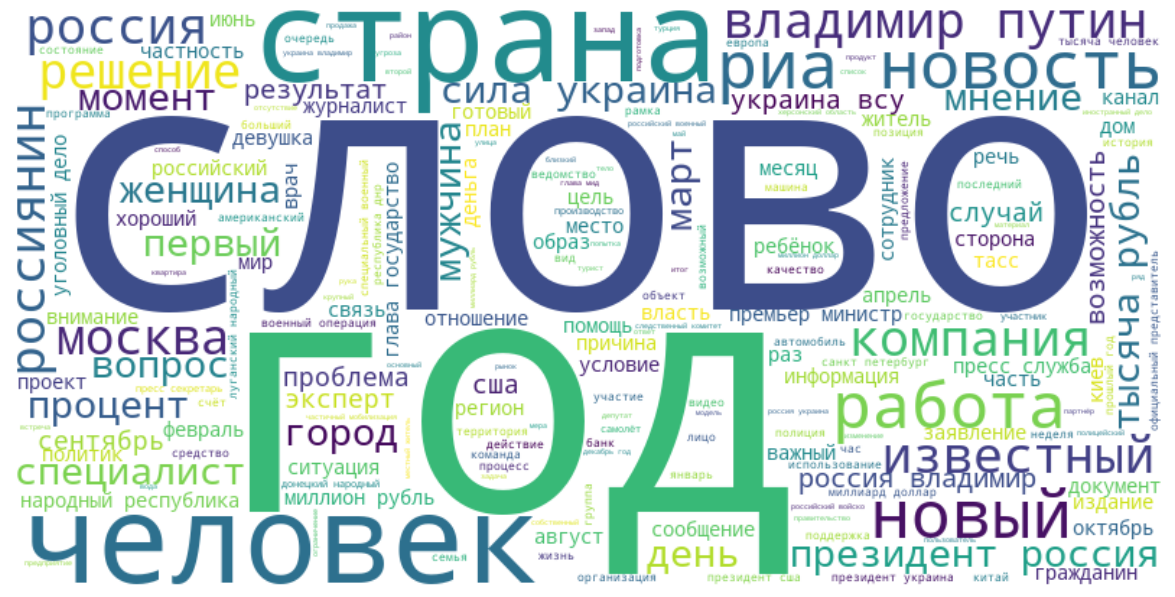

In [44]:
nlp = spacy.load("ru_core_news_sm")

extra_stopwords = {
    "сообщает", "сказал", "заявил", "отметил", "добавил", "сообщается",
    "по данным", "раннее", "ранее", "сообщил", "сегодня", "сейчас",
    "около", "около", "пише", "время", "темп", "число", "сегодня", "пока",
}

texts = df_critical['text'].fillna("").astype(str).str.lower()

lemmas = []
for doc in nlp.pipe(texts, disable=["parser", "ner"]):
    for token in doc:
        lemma = token.lemma_.strip()
        if (
            token.pos_ in {"NOUN", "PROPN", "ADJ"} 
            and not token.is_stop 
            and lemma not in extra_stopwords 
            and len(lemma) > 2
            and re.fullmatch(r"[а-яё]+", lemma)  
        ):
            lemmas.append(lemma)

text_for_cloud = " ".join(lemmas)

wc = WordCloud(
    background_color="white",
    stopwords=set(),  
    width=800,
    height=400
)

wc.generate(text_for_cloud)

plt.figure(figsize=(15, 7.5))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

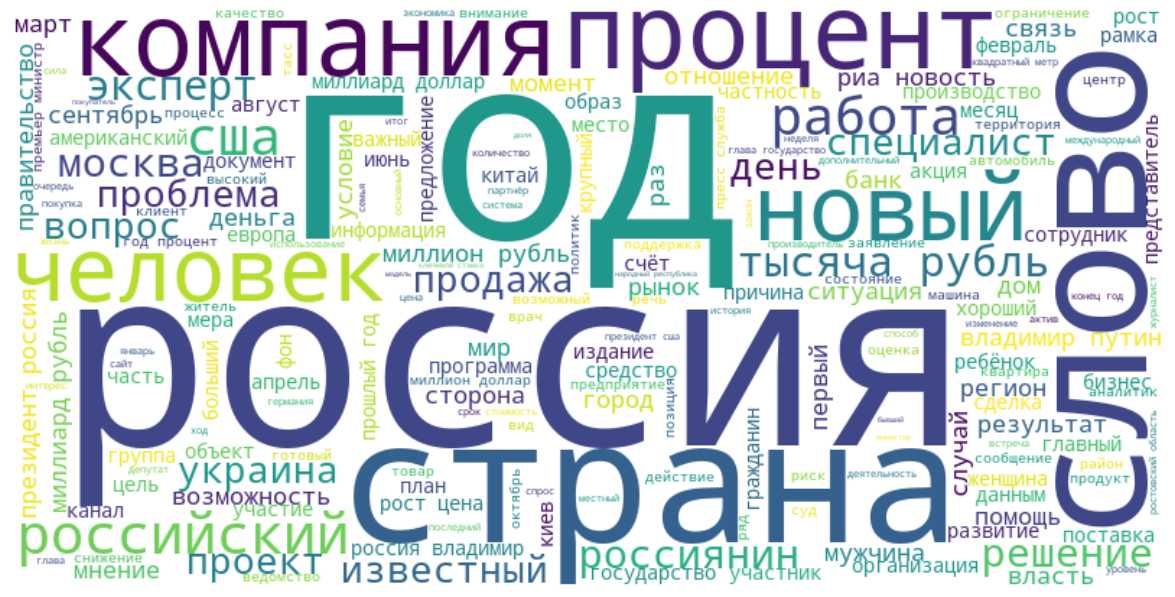

In [45]:
extra_stopwords = {
    "сообщает", "сказал", "заявил", "отметил", "добавил", "сообщается",
    "по данным", "ранее", "сообщил", "сегодня", "сейчас",
    "около", "пише", "время", "темп", "число", "пока"
}

mask_biz = df_critical['sentiment'].isin(['biz_positive', 'biz_negative', 'biz_neutral'])
texts_biz = df_critical.loc[mask_biz, 'text'].astype(str).str.lower()


if texts_biz.empty:
    print("no business info in df_critical")
else:
    lemmas = []
    for doc in nlp.pipe(texts_biz, disable=["parser", "ner"]):
        for token in doc:
            lemma = token.lemma_.strip()
            if (
                token.pos_ in {"NOUN", "PROPN", "ADJ"}
                and not token.is_stop
                and lemma not in extra_stopwords
                and len(lemma) > 2
                and re.fullmatch(r"[а-яё]+", lemma)
            ):
                lemmas.append(lemma)

    text_for_cloud = " ".join(lemmas)

    wc = WordCloud(
        background_color="white",
        stopwords=set(),   
        width=800,
        height=400
    )
    wc.generate(text_for_cloud)

    plt.figure(figsize=(15, 7.5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

The 10 most popular bigrams

In [59]:
results = []
for d in critical_dates:
    start = d - timedelta(days=3)
    end = d + timedelta(days=3)
    start_ts = pd.to_datetime(start)
    end_ts = pd.to_datetime(end)
    subset = df_critical[(df_critical['date'] >= start_ts) & (df_critical['date'] <= end_ts)]
    text = ' '.join(subset['title'].fillna('') + ' ' + subset['text'].fillna(''))
    tokens = re.findall(r'\b[а-яё]{2,}\b', text.lower())
    bigrams = zip(tokens, tokens[1:])
    counter = Counter(bigrams)
    for bigram, cnt in counter.most_common(10):
        results.append({
            'date_center': d,
            'window_start': start,
            'window_end': end,
            'bigram': ' '.join(bigram),
            'count': cnt
        })

df_bigrams = pd.DataFrame(results)
df_bigrams.head(10)

date_center window_start  window_end          bigram  count
0  2020-01-20   2020-01-17  2020-01-23         об этом    919
1  2020-01-20   2020-01-17  2020-01-23           из за    461
2  2020-01-20   2020-01-17  2020-01-23   этом сообщает    365
3  2020-01-20   2020-01-17  2020-01-23          по его    262
4  2020-01-20   2020-01-17  2020-01-23       по словам    238
5  2020-01-20   2020-01-17  2020-01-23      заявил что    224
6  2020-01-20   2020-01-17  2020-01-23  сообщалось что    216
7  2020-01-20   2020-01-17  2020-01-23        во время    207
8  2020-01-20   2020-01-17  2020-01-23      его словам    186
9  2020-01-20   2020-01-17  2020-01-23        при этом    177

In [64]:
nlp = spacy.load("ru_core_news_sm")
counter_ent = Counter()

for doc in nlp.pipe(df_critical['text'].astype(str), batch_size=50):
    for ent in doc.ents:
        if ent.label_ in {"PER", "ORG", "LOC"} and len(ent) > 1:
            counter_ent[ent.text] += 1

top_entities = counter_ent.most_common(20)
top_entities

[('РИА Новости', 3454),
 ('Владимир Путин', 1722),
 ('Вооруженных сил Украины (ВСУ)', 1117),
 ('Telegram-канал', 899),
 ('Telegram-канале', 733),
 ('Владимира Путина', 654),
 ('Дмитрий Песков', 614),
 ('Владимир Зеленский', 566),
 ('Вооруженных сил', 545),
 ('Херсонской области', 499),
 ('Следственного комитета', 491),
 ('Джо Байден', 469),
 ('Московской области', 462),
 ('Российской Федерации', 435),
 ('Вооруженные силы Украины (ВСУ)', 434),
 ('Санкт-Петербурге', 416),
 ('Донецкой народной республики (ДНР)', 392),
 ('Запорожской области', 389),
 ('России (СКР)', 381),
 ('Владимира Зеленского', 379)]